In [64]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import random
from matplotlib.patches import Rectangle
from lxml import etree
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.applications import ResNet50

In [2]:
image_path = glob.glob('defects location for metal surface dataset/images/images/*/*.jpg')
len(image_path)

2306

In [3]:
image_path[:3]

['defects location for metal surface dataset/images/images\\crease\\img_01_3436789500_00004.jpg',
 'defects location for metal surface dataset/images/images\\crease\\img_01_425382900_00002.jpg',
 'defects location for metal surface dataset/images/images\\crease\\img_01_425501700_00022.jpg']

In [4]:
xmls_path = glob.glob('defects location for metal surface dataset/label/label/*.xml')
len(xmls_path)

2280

In [5]:
xmls_path[:3]

['defects location for metal surface dataset/label/label\\img_01_3402617700_00001.xml',
 'defects location for metal surface dataset/label/label\\img_01_3402617700_01009.xml',
 'defects location for metal surface dataset/label/label\\img_01_3436789500_00004.xml']

In [6]:
#xml_name extraction
xmls_train = [p.split('\\')[-1].split('.')[0] for p in xmls_path]
xmls_train[:3]

['img_01_3402617700_00001',
 'img_01_3402617700_01009',
 'img_01_3436789500_00004']

In [7]:
#img_name extraction
imgs_train = [img for img in image_path if (img.split('\\')[-1].split)('.jpg')[0] in xmls_train]
imgs_train[:3]

['defects location for metal surface dataset/images/images\\crease\\img_01_3436789500_00004.jpg',
 'defects location for metal surface dataset/images/images\\crease\\img_01_425382900_00002.jpg',
 'defects location for metal surface dataset/images/images\\crease\\img_01_425501700_00022.jpg']

In [8]:
len(imgs_train),len(xmls_path)

(2280, 2280)

In [9]:
#check the image to label sorts
xmls_path.sort(key=lambda x:x.split('/')[-1].split('.xml')[0])
imgs_train.sort(key=lambda x:x.split('/')[-1].split('.jpg')[0])
xmls_path[:3],imgs_train[:3]

(['defects location for metal surface dataset/label/label\\img_01_3402617700_00001.xml',
  'defects location for metal surface dataset/label/label\\img_01_3402617700_01009.xml',
  'defects location for metal surface dataset/label/label\\img_01_3436789500_00004.xml'],
 ['defects location for metal surface dataset/images/images\\crease\\img_01_3436789500_00004.jpg',
  'defects location for metal surface dataset/images/images\\crease\\img_01_425382900_00002.jpg',
  'defects location for metal surface dataset/images/images\\crease\\img_01_425501700_00022.jpg'])

In [10]:
names = [x.split("\\")[-2] for x in imgs_train]
names[:3]

['crease', 'crease', 'crease']

In [11]:
names = pd.DataFrame(names,columns=['Types'])
names

,Types
0,crease
1,crease
2,crease
3,crease
4,crease
...,...
2275,welding_line
2276,welding_line
2277,welding_line
2278,welding_line


In [12]:
#onehot for mutiple classes
from sklearn.preprocessing import LabelBinarizer

Class = names['Types'].unique()
Class_dict = dict(zip(Class, range(1,len(Class)+1)))
names['str'] = names['Types'].apply(lambda x: Class_dict[x])
lb = LabelBinarizer()
lb.fit(list(Class_dict.values()))
transformed_labels = lb.transform(names['str'])
y_bin_labels = []  

for i in range(transformed_labels.shape[1]):
    y_bin_labels.append('str' + str(i))
    names['str' + str(i)] = transformed_labels[:, i]

In [13]:
Class_dict

{'crease': 1,
 'crescent_gap': 2,
 'inclusion': 3,
 'oil_spot': 4,
 'punching_hole': 5,
 'rolled_pit': 6,
 'silk_spot': 7,
 'waist folding': 8,
 'water_spot': 9,
 'welding_line': 10}

In [14]:
names.drop('str',axis=1,inplace=True)
names.drop('Types',axis=1,inplace=True)
names.head()

,str0,str1,str2,str3,str4,str5,str6,str7,str8,str9
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [15]:
#analysis rectangular box value in xmls
def to_labels(path):
    xml = open('{}'.format(path)).read()                         #read xml in path 
    sel = etree.HTML(xml)                     
    width = int(sel.xpath('//size/width/text()')[0])     #extract the width/height
    height = int(sel.xpath('//size/height/text()')[0])    #extract the x,y value
    xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
    xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
    ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
    ymax = int(sel.xpath('//bndbox/ymax/text()')[0])
    return [xmin/width, ymin/height, xmax/width, ymax/height]   #return the four relative points 

In [16]:
labels = [to_labels(path) for path in xmls_path]
labels[:3]

[[0.8486328125, 0.806, 0.951171875, 0.993],
 [0.857421875, 0.298, 0.96044921875, 0.858],
 [0.47900390625, 0.182, 0.9990234375, 0.249]]

In [87]:
#set four labels as outputs
out1,out2,out3,out4 = list(zip(*labels))        
#convert to np.array
out1 = np.array(out1)
out2 = np.array(out2)
out3 = np.array(out3)
out4 = np.array(out4)
label = np.array(names.values)

In [86]:
np

<module 'numpy' from 'C:\\Users\\Roland\\anaconda3\\lib\\site-packages\\numpy\\__init__.py'>

In [18]:
label_datasets = tf.data.Dataset.from_tensor_slices((out1,out2,out3,out4,label))
label_datasets

<TensorSliceDataset shapes: ((), (), (), (), (10,)), types: (tf.float64, tf.float64, tf.float64, tf.float64, tf.int32)>

In [19]:
def load_image(path):
    image = tf.io.read_file(path)                           
    image = tf.image.decode_jpeg(image,3)               
    image = tf.image.resize(image,[224,224])               
    image = tf.cast(image/127.5-1,tf.float32)                 
    return image 

In [20]:
dataset = tf.data.Dataset.from_tensor_slices(imgs_train)
dataset = dataset.map(load_image)

In [21]:
dataset_label = tf.data.Dataset.zip((dataset,label_datasets))

In [22]:
#batch constant
BATCH_SIZE = 16
AUTO = tf.data.experimental.AUTOTUNE

In [23]:
dataset_label = dataset_label.repeat().shuffle(500).batch(BATCH_SIZE)
dataset_label = dataset_label.prefetch(AUTO)

In [24]:
#Split dataset
test_count = int(len(imgs_train)*0.2)
train_count = len(imgs_train) - test_count
test_count,train_count

(456, 1824)

In [25]:
train_dataset = dataset_label.skip(test_count)
test_dataset = dataset_label.take(test_count)

In [26]:
train_dataset

<SkipDataset shapes: ((None, 224, 224, 3), ((None,), (None,), (None,), (None,), (None, 10))), types: (tf.float32, (tf.float64, tf.float64, tf.float64, tf.float64, tf.int32))>

In [27]:
species_dict = {v:k for k,v in Class_dict.items()}

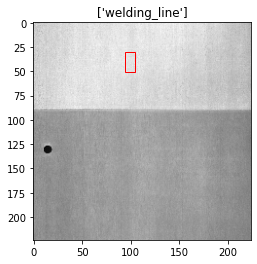

In [28]:
#check from train_data
for img, label in train_dataset.take(1):
    plt.imshow(keras.preprocessing.image.array_to_img(img[0]))     
    out1,out2,out3,out4,out5 = label                            
    xmin,ymin,xmax,ymax = out1[0].numpy()*224,out2[0].numpy()*224,out3[0].numpy()*224,out4[0].numpy()*224
    rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='r')  
    ax = plt.gca()                      
    ax.axes.add_patch(rect)   
    pred_imglist = []
    pred_imglist.append(species_dict[np.argmax(out5[0])+1])
    plt.title(pred_imglist)
    plt.show()

In [97]:
#Convolution based
conv = keras.applications.xception.Xception(weights='imagenet',
                                            include_top=False,
                                            input_shape=(224,224,3),
                                            pooling='avg')

In [98]:
conv.trainable = True

In [99]:
model = Sequential()
#from from tensorflow.keras.applications.resnet50 import preprocess_inputfrom tensorflow.keras.applications.resnet50 import preprocess_input import preprocess_input
model.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))

model.add(Dense(10, activation='sigmoid'))

model.layers

model.layers[0].trainable = False

In [100]:
model.compile(tf.keras.optimizers.Adam(0.0003),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [101]:
lr_reduce = keras.callbacks.ReduceLROnPlateau('val_loss', patience=6, factor=0.5, min_lr=1e-6)

In [102]:
history = model.fit_generator(train_dataset,
                   steps_per_epoch=train_count//BATCH_SIZE,
                   epochs=2,
                   validation_data=test_dataset,
                   validation_steps=test_count//BATCH_SIZE)

Epoch 1/2


AttributeError: in user code:

    C:\Users\Roland\anaconda3\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\Roland\anaconda3\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Roland\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Roland\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Roland\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Roland\anaconda3\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\Roland\anaconda3\lib\site-packages\keras\engine\training.py:792 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    C:\Users\Roland\anaconda3\lib\site-packages\keras\engine\compile_utils.py:436 update_state
        self.build(y_pred, y_true)
    C:\Users\Roland\anaconda3\lib\site-packages\keras\engine\compile_utils.py:358 build
        self._metrics = tf.__internal__.nest.map_structure_up_to(y_pred, self._get_metric_objects,
    C:\Users\Roland\anaconda3\lib\site-packages\tensorflow\python\util\nest.py:1376 map_structure_up_to
        return map_structure_with_tuple_paths_up_to(
    C:\Users\Roland\anaconda3\lib\site-packages\tensorflow\python\util\nest.py:1474 map_structure_with_tuple_paths_up_to
        results = [
    C:\Users\Roland\anaconda3\lib\site-packages\tensorflow\python\util\nest.py:1475 <listcomp>
        func(*args, **kwargs) for args in zip(flat_path_gen, *flat_value_gen)
    C:\Users\Roland\anaconda3\lib\site-packages\tensorflow\python\util\nest.py:1378 <lambda>
        lambda _, *values: func(*values),  # Discards the path arg.
    C:\Users\Roland\anaconda3\lib\site-packages\keras\engine\compile_utils.py:482 _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\Roland\anaconda3\lib\site-packages\keras\engine\compile_utils.py:482 <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\Roland\anaconda3\lib\site-packages\keras\engine\compile_utils.py:503 _get_metric_object
        y_t_rank = len(y_t.shape.as_list())

    AttributeError: 'tuple' object has no attribute 'shape'


In [ ]:
image = tf.keras.preprocessing.image.load_img(image_path)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)

In [42]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input

In [43]:
num_classes = 2

#VGG16 was originally trained on 224 × 224 images, so the images were resized.
image_resize = 224

batch_size_training = 10
batch_size_validation = 10

In [45]:
#ImageDataGenerator for the training set and another one for the validation set. 

vgg_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

vgg_train_generator =  tf.keras.preprocessing.image.load_img(
    train_dataset,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

vgg_validation_generator =  tf.keras.preprocessing.image.load_img(
    test_dataset,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical')

TypeError: load_img() got an unexpected keyword argument 'batch_size'